# EA1:

*By Daniel Deutsch, José Lucas Barretto, and Stéphane Roblet*

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.tsa.stattools as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA as arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

## Motivation

## Moody's AAA Corporate Bond Yields

### Load the Data

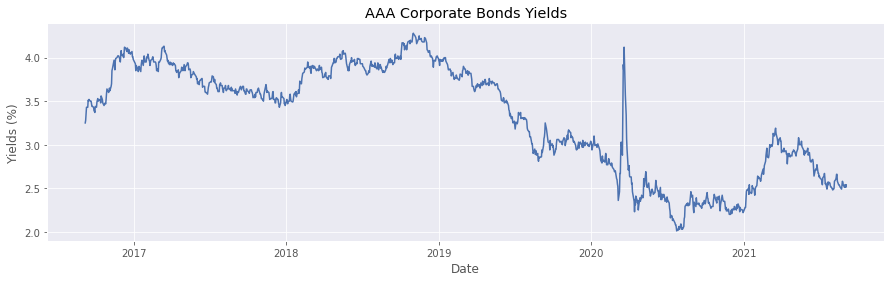

In [92]:
# Loads data and makes small modifications on the df
df_aaa = pd.read_csv("datasets/AAA_corpbonds_yields.csv", na_values='.')
df_aaa['DATE'] = pd.to_datetime(df_aaa['DATE'], format='%Y-%m-%d')
df_aaa.rename(columns={'DATE': 'date', 'DAAA': 'value'}, inplace=True)
df_aaa.dropna(inplace=True)

# Plots the time series
plt.plot(df_aaa['date'], df_aaa['value'])
plt.title("AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

### Augmented Dickey-Fuller Test

First, we shall perform the Augmented Dickey-Fuller test to verify if the series has a drift/deterministic trend, and if it has a unit root. The test has the following as hypotesis:

<br>

$$
    H_0: \text{there is a unit root.} \\
    H_1: \text{there is no unit root (the time series is stationary).}
$$

<br>

If the pvalue is above a critical size, then we cannot reject that there is a unit root. We start by running a general regression (includes constant and trend).

In [87]:
adf_res = sm.adfuller(df_aaa['value'], regression='ct', maxlag=12, autolag='AIC', regresults=True)

print('ADF Results (Constant + Trend):')
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results (Constant + Trend):
t-value: -2.6581795512232533
p-value: 0.2538535302995324
used lags: 9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     5.337
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           2.63e-08
Time:                        15:38:41   Log-Likelihood:                 1955.7
No. Observations:                1241   AIC:                            -3887.
Df Residuals:                    1229   BIC:                            -3826.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

1. We verify that p-value for the ADF is not low enough, which means that we do not reject $H_0: \rho = 0$.

2. Then, we verify if the coefficient of the trend is statistically significant. Since the t-stat for x11 = -2.539, we conclude that the coef. of the trend is not statistically significant compared to the critical value of 2.78 at the 5% cofidence level.

3. The next step is to run the test again without the trend term.

In [88]:
adf_res = sm.adfuller(df_aaa['value'], regression='c', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results (Constant):') 
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results (Constant):
t-value: -1.033952299163931
p-value: 0.7406804882311704
used lags: 9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     5.203
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           1.66e-07
Time:                        15:38:47   Log-Likelihood:                 1952.5
No. Observations:                1241   AIC:                            -3883.
Df Residuals:                    1230   BIC:                            -3827.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

- We do not reject the non-stationarity hypothesis, because the p-value is 0.713.
- Then, we check that constant term is NOT statistically significant, because its t-value is not high enough.
- The next step is to run a restricted regression (no constand and no trend.)

In [97]:
adf_res = sm.adfuller(df_aaa['value'], regression='nc', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results:') 
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results:
t-value: -0.7469882196814754
p-value: 0.39281257611444154
used lags: 9
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.040
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              5.149
Date:                Tue, 14 Sep 2021   Prob (F-statistic):                    2.06e-07
Time:                        15:41:44   Log-Likelihood:                          1952.1
No. Observations:                1241   AIC:                                     -3884.
Df Residuals:                    1231   BIC:                                     -3833.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err    

Since we cannot reject the non-stationarity hypothesis, the ADF test suggests that the series is non-stationary without constant. This means that the series has a unit root (stochastic trend), but no drift. We can check this result by running the ADF test on the first difference of the series.

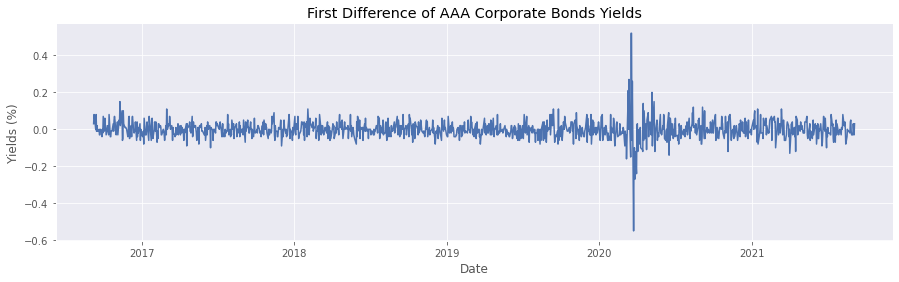

In [94]:
df_aaa['diff'] = df_aaa['value'].diff()

# Plots the first difference time series
plt.plot(df_aaa['date'], df_aaa['diff'])
plt.title("First Difference of AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

In [99]:
adf_res = sm.adfuller(df_aaa['diff'].dropna(), regression='ct', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results:') 
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results:
t-value: -13.713251329275632
p-value: 2.064779226403604e-21
used lags: 8
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     131.1
Date:                Tue, 14 Sep 2021   Prob (F-statistic):          6.81e-186
Time:                        15:45:23   Log-Likelihood:                 1952.2
No. Observations:                1241   AIC:                            -3882.
Df Residuals:                    1230   BIC:                            -3826.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

By running the ADF test on the first difference series, we obtain the result that the non-stationarity hypothesis is rejected, which means that AAA Corporate Bond Yields are I(1). We can also see that both the constant and trend coefficients are not significant, suggesting that the first difference series does not have drift or trend.

### Decomposition and Analysis of Drift, Trend, and Seasonality for the First Difference Series

Now, we shall decompose the first difference series into trend, seasonality, and residues (cyclical component). We will assume that the series follow an annual period, and thus, we consider a period of 253 days (average number of trading days per year).

In [147]:
decomposition = seasonal_decompose(df_aaa['diff'].dropna(), model='additive', period=253)

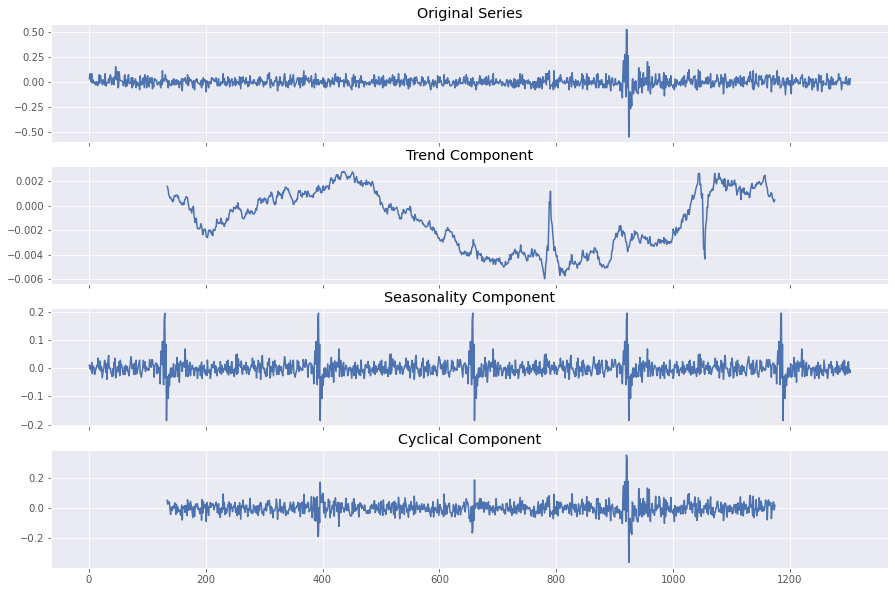

In [196]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(15,10))

df_aaa['diff'].plot(ax=ax[0])
decomposition.trend.plot(ax=ax[1])
decomposition.seasonal.plot(ax=ax[2])
decomposition.resid.plot(ax=ax[3])

ax[0].set_title("Original Series")
ax[1].set_title("Trend Component")
ax[2].set_title("Seasonality Component")
ax[3].set_title("Cyclical Component")

plt.show()

#### Deterministic Trend

In [151]:
model = OLS(df_aaa['diff'].dropna(), decomposition.trend, missing='drop')
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              2.915
Date:                Tue, 14 Sep 2021   Prob (F-statistic):                      0.0881
Time:                        16:16:02   Log-Likelihood:                          1511.8
No. Observations:                 998   AIC:                                     -3022.
Df Residuals:                     997   BIC:                                     -3017.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We can see that the trend component is not statistical significant at the 5% level, which confirms our previous findings. Therefore, these results indicate that the series don't have a deterministic trend when considering an annual period.

#### Seasonality

In [152]:
model = OLS(df_aaa['diff'].dropna(), decomposition.seasonal, missing='drop')
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.173
Model:                            OLS   Adj. R-squared (uncentered):              0.172
Method:                 Least Squares   F-statistic:                              260.8
Date:                Tue, 14 Sep 2021   Prob (F-statistic):                    2.00e-53
Time:                        16:16:10   Log-Likelihood:                          2060.0
No. Observations:                1250   AIC:                                     -4118.
Df Residuals:                    1249   BIC:                                     -4113.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We can see that the seasonal component is statistically significant, when considering a period equivalent to the trading year, indicating that there's seasonality in the series. We can also verify this by using dummy variables for each month and verifying their statistical significance.

In [185]:
# create dummy vars columns for week of the year
df_aaa['period'] = df_aaa['date'].dt.weekofyear

# create a column for each dummy var
for period in df_aaa['period'].unique():
    df_aaa[f'is_{period}'] = 1*(df_aaa['period'] == period)

# include all dummy vars except one
X = df_aaa[[f'is_{period}' for period in sorted(df_aaa['period'].unique())[:-1]]]

# run regression
model = OLS(df_aaa['diff'], X, missing='drop')
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.065
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              1.599
Date:                Tue, 14 Sep 2021   Prob (F-statistic):                     0.00493
Time:                        16:43:05   Log-Likelihood:                          1983.4
No. Observations:                1250   AIC:                                     -3863.
Df Residuals:                    1198   BIC:                                     -3596.
Df Model:                          52                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


The results indicate that some weeks of the year have statistically significant impacts on the value of the first difference series. This supports the previous finding that the series has a significant seasonal component.

### Stationary ARMA Model

The goal here is to estimate the cyclical component through a stationary ARMA model. First, let's estimate the parameters q and p through the autocorrelation and partial autocorrelation of the series.

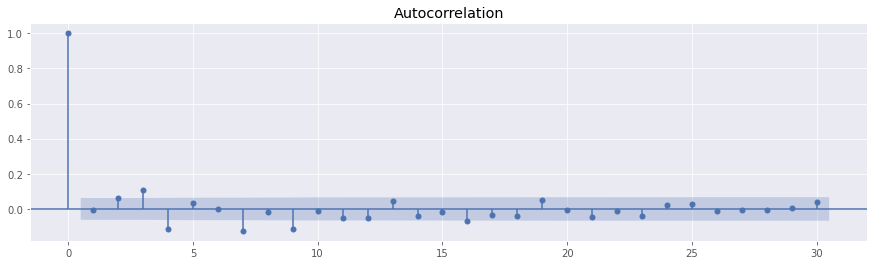

In [201]:
plot_acf(decomposition.resid.dropna())
plt.show()

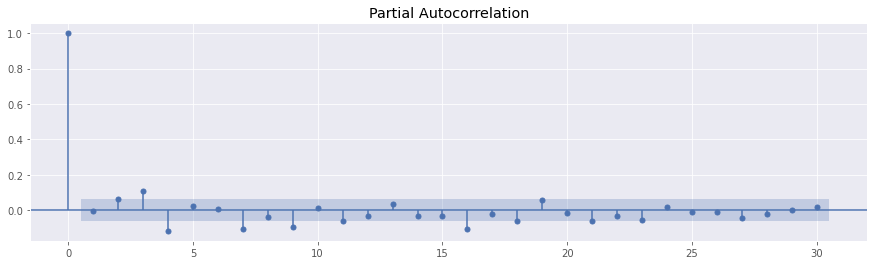

In [200]:
plot_pacf(decomposition.resid.dropna())
plt.show()

From the autocorrelation plot we can estimate that values are close enough to zero when $q>9$, and from the partial autocorrelation plot, we can estimate the same when $p>7$. Now, we can fit the model and verify the results.

In [208]:
arma_model = arima(decomposition.resid.dropna(), order=(9,0,7))
res = arma_model.fit()
print(res.summary())

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressi

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  998
Model:                 ARIMA(9, 0, 7)   Log Likelihood                1716.103
Date:                Tue, 14 Sep 2021   AIC                          -3396.206
Time:                        17:04:37   BIC                          -3307.903
Sample:                             0   HQIC                         -3362.641
                                - 998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.285      0.776      -0.001       0.002
ar.L1          0.0299      0.365      0.082      0.935      -0.685       0.745
ar.L2          0.1119      0.262      0.428      0.6

## NYSE Stock Yields

### Load the Data

In [ ]:
# Loads data and makes small modifications on the df
df_nyse = pd.read_csv("datasets/NYSE_stock_yields.csv", na_values='.')
df_nyse['DATE'] = pd.to_datetime(df_nyse['DATE'], format='%Y-%m-%d')
df_nyse.rename(columns={'DATE': 'date', 'M1346BUSM156NNBR': 'value'}, inplace=True)
df_nyse.dropna(inplace=True)

# Applies log-transform
df_nyse['value'] = np.log(df_nyse['value'])

# Plots the time series
plt.plot(df_nyse['date'], df_nyse['value'])
plt.title("NYSE Stock Yields")
plt.xlabel("Date")
plt.ylabel("Logarithm of Yields (%)")
plt.show()

### Decomposition and Analysis of Drift, Trend, and Seasonality

#### Deterministic Trend

#### Seasonality

### Augmented Dickey-Fuller Test

### Stationary ARMA Model

## US Treasury Bond Yields

### Load the Data

In [ ]:
# Loads data and makes small modifications on the df
df_us = pd.read_csv("datasets/US_govbonds_yields.csv", na_values='.')
df_us['DATE'] = pd.to_datetime(df_us['DATE'], format='%Y-%m-%d')
df_us.rename(columns={'DATE': 'date', 'IRLTLT01USM156N': 'value'}, inplace=True)
df_us.dropna(inplace=True)

# Applies log-transform
df_us['value'] = np.log(df_us['value'])

# Plots the time series
plt.plot(df_us['date'], df_us['value'])
plt.title("US Governament Bond Yields")
plt.xlabel("Date")
plt.ylabel("Logarithm of Yields (%)")
plt.show()

### Decomposition and Analysis of Drift, Trend, and Seasonality

#### Deterministic Trend

#### Seasonality

### Augmented Dickey-Fuller Test

### Stationary ARMA Model